Questions that need to be answered:

1) Whom to approve or reject for the credit card?
2) How much credit limit to give if approved?


Information on Columns in Dataset - 

### User Information
- user_id
- gender
- date_of_birth
- workclass
- education_level
- education_num: education_level as a continuous variable. Eg, Masters(14) >
Bachelors(13)
- marital_status
- occupation
- relationship: current relationship status
- capital_gain: capital gain made in the last financial year in USD through investments
- capital_loss: capital loss in the last financial year in USD through investments
- Hours_per_week: Number of hours worked by the person per week.
- approved: Whether customer was approved for the Credit Card.
- address
- Email


### CIBIL Information

- Inquiry_purpose_code: Purpose of enquiry from the bureau
- Institute_type: Type of institute that requested the bureau
- Account_type: Type of account of the customer for requesting from the bureau
- Asset_class_cd: Current state of the assets of the customer
- Asset_code: Type of ownership of the customer
- Portfolio_type: Type of portfolio

In [115]:
# !pip3 install lux pyforest scipy sklearn lazypredict lux-api
# !pip3 uninstall lux lux-api -y
!pip3 install scikit-learn==0.23
# !pip install pandas-profiling[notebook]

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.3 MB 6.6 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ludwig 0.3.3 requires pandas<1.1.5,>=0.19, but you have pandas 1.1.5 which is incompatible.
lazypredict 0.2.9 requires joblib==1.0.0, but you have joblib 1.0.1 which is incompatible.
lazypredict 0.2.9 requires numpy==1.19.1, but you have numpy 1.19.5 which is incompatible.
lazypredict 0.2.9 requires pandas==1.0.5, but you have pandas 1.1.5 which is incompatible.
lazypredict 0.2.9 requires scikit-learn==0.23.1, but you have scikit-learn 0.23.0 which is incompatible.
You should consider upgrading 

In [32]:
%load_ext autoreload
%autoreload 2
import pyforest
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score
# import lux
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from datetime import datetime, date
import lazypredict
from lazypredict.Supervised import LazyClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_data = pd.read_csv('./simpl_payments_bank_digicard_v1.0.csv')
print(all_data.dtypes)
target_variable = 'approved' 

user_id                  object
gender                   object
date_of_birth            object
workclass                object
education_level          object
education_num           float64
marital_status           object
occupation               object
relationship             object
capital_gain            float64
capital_loss            float64
hours_per_week          float64
approved                  int64
address                  object
email                    object
inquiry_purpose_code    float64
institute_type           object
account_type              int64
asset_class_cd           object
asset_code              float64
portfolio_type           object
dtype: object


In [92]:
# all_data.groupby("gender")["approved"].mean()
# gender = {" Male": 1," Female": 2}
# all_data.gender = [gender[item] for item in all_data.gender]
# # print(all_data.dtypes)
# all_data.groupby("gender")["approved"].mean()

gender
1    0.312477
2    0.113576
Name: approved, dtype: float64

In [4]:
#Feature Engineering
def age(date_of_birth):
    date_of_b = datetime.strptime(date_of_birth, "%Y-%m-%d").date()
    today = date.today()
    return today.year - date_of_b.year - ((today.month, today.day) < (date_of_b.month, date_of_b.day))

all_data['Age'] = all_data['date_of_birth'].apply(age)
all_data['gender'] = all_data['gender'].apply(lambda x: 1 if x == ' Male' else 2)

# all_data["approved"] = all_data["approved"].astype(np.float64)
# all_data[["approved"]] = all_data[["approved"]].apply(pd.to_numeric)

In [95]:
all_data.corrwith(all_data[target_variable])

gender                 -0.215760
education_num           0.332800
capital_gain            0.221034
capital_loss            0.148687
hours_per_week          0.227199
approved                1.000000
inquiry_purpose_code    0.084895
account_type           -0.056301
asset_code             -0.000352
Age                     0.237040
dtype: float64

In [96]:
profile = ProfileReport(all_data, title="Pandas Profiling Report", html={'style':{'full_width':True}}, dark_mode = True)
profile.to_widgets()
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

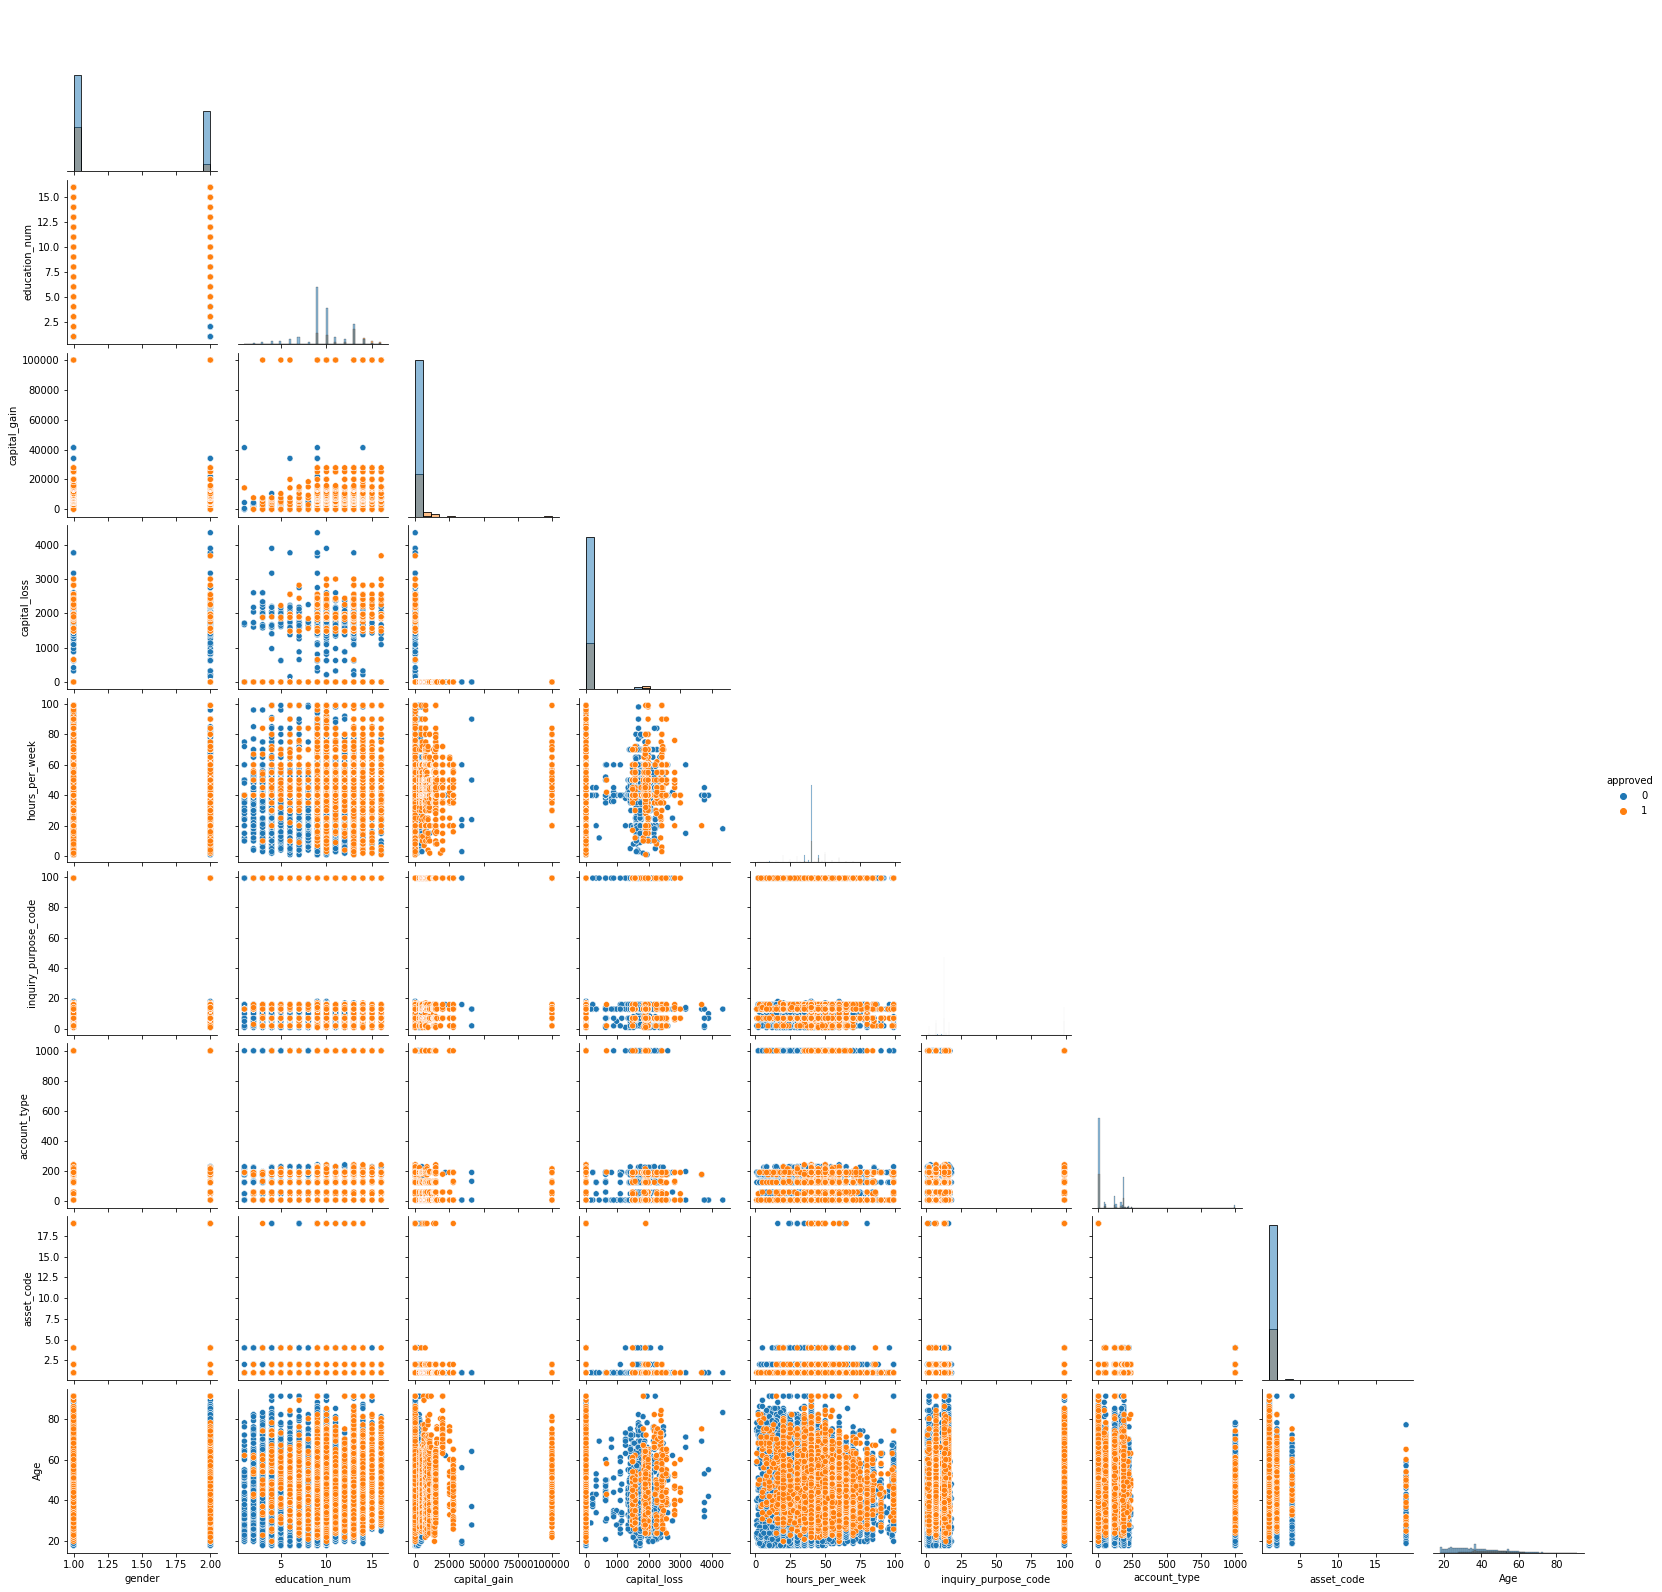

In [97]:
import seaborn as sns
sns.pairplot(all_data, hue = target_variable, diag_kind="hist", corner=True)

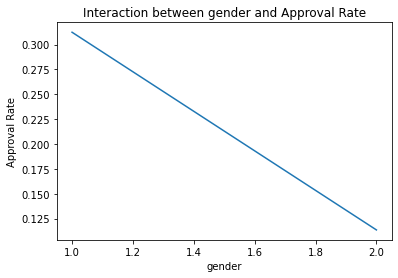

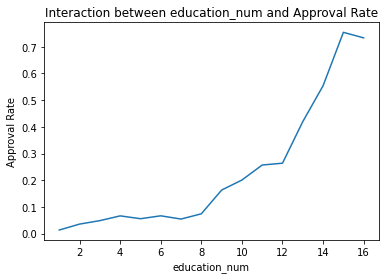

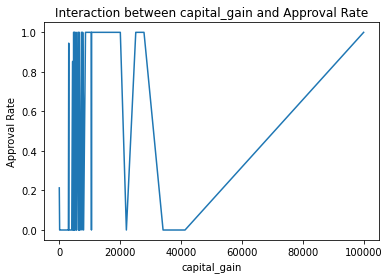

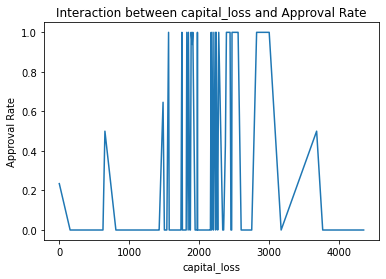

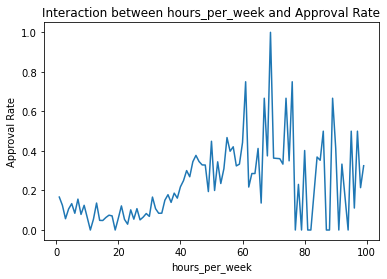

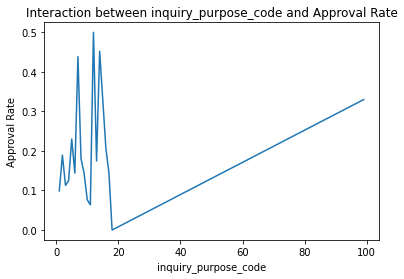

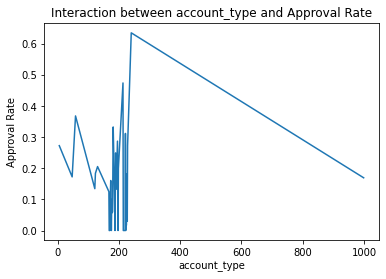

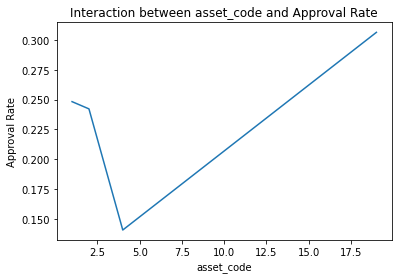

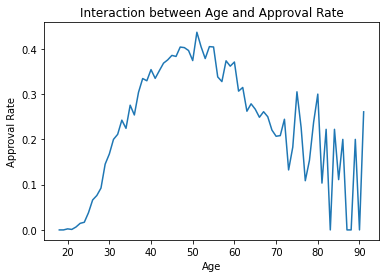

In [98]:
import matplotlib.pyplot as plt

numeric_columns = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove(target_variable)

for column_name in numeric_columns:
    plt.figure()
    df = all_data.groupby(column_name)[target_variable].mean().reset_index()
    plt.plot(df[column_name],df[target_variable])
    plt.title("Interaction between " + str(column_name) + " and Approval Rate")
    plt.xlabel(column_name)
    plt.ylabel("Approval Rate")
    plt.show()


In [72]:
df = all_data.groupby('asset_code')[target_variable].mean().reset_index()
df

,asset_code,approved
0,1.00,0.25
1,2.00,0.24
2,4.00,0.14
3,19.00,0.31


In [96]:
df = {228 : 'Mudra Loan (Shishu/Kishor/Tarun)',227 : 'Pradhan Mantri JDY (Over Draft)',226 : 'Loan on Credit Card',225 : 'Kisan Credit Card',224 : 'Corporate Credit Card',213 : 'Tractor Loan',223 : 'Construction Equipment Loan',222 : 'Used Car Loan',221 : 'Secured Credit Card',220 : 'Loan, Staff',196 : 'Business Loan Against Bank Deposits',175 : 'Non-Funded Credit Facility, Priority Sector - Others',200 : 'Non-Funded Credit Facility, Priority Sector - Agriculture',199 : 'Non-Funded Credit Facility, Priority Sector - Small Buisiness',198 : 'Non-Funded Credit Facility, General',197 : 'Business Loan - Priority Sector - Others',179 : 'Business Loan - Priority Sector - Agriculture',178 : 'Business Loan - Priority Sector - Small Business',177 : 'Business Loan - General',176 : 'Microfinance, Other',170 : 'Microfinance, Housing',168 : 'Microfinance, Personal',167 : 'Microfinance, Business',216 : 'Service, Telco - Landline',215 : 'Service, Telco - Broadband',217 : 'Service, Telco - Wireless',172 : 'Instalment Loan, Commercial Vehicle',214 : 'Credit Card, Fleet',184 : 'Loan Against Bank Deposits',181 : 'Credit Facility, Non-Funded',173 : 'Instalment Loan, Two-Wheeler',121 : 'Banking, Overdraft',219 : 'Leasing, Other',5 : 'Credit Card',187 : 'Loan to Professional',130 : 'Loan, Student',191 : 'Loan, Gold',189 : 'Loan, Consumer',123 : 'Loan, Personal Cash',185 : 'Loan Against Shares/Securities',195 : 'Loan, Property',58 : 'Instalment Loan, Mortgage',47 : 'Instalment Loan, Automobile',999 : 'Other'}

all_data["account_type_"] = [df.get(item, str(item) + " Not Given") for item in all_data.account_type]
df = all_data.groupby('account_type_')[target_variable].mean().reset_index()
df.sort_values(by=['approved'], ascending=False)

,account_type_,approved
0,240 Not Given,0.64
35,Tractor Loan,0.47
13,"Instalment Loan, Mortgage",0.37
10,"Credit Facility, Non-Funded",0.33
34,Secured Credit Card,0.31
22,"Loan, Property",0.29
8,Credit Card,0.27
29,Mudra Loan (Shishu/Kishor/Tarun),0.27
19,"Loan, Consumer",0.25
24,"Loan, Student",0.21


In [97]:
df = {99 : 'Others',19 : 'Credit Review',18 : 'Consumer loan',17 : 'Working capital loan',16 : 'Two/Three wheeler loan',15 : 'Telecom',14 : 'Property Loan',13 : 'Personal Loan',12 : 'Non-funded credit facility',11 : 'Microfinance',10 : 'Load Against Collateral',9 : 'Leasing',8 : 'Education Load',7 : 'Credit Card',6 : 'Consumer Search',5 : 'Construction Euipment Loans',4 : 'Commercial Vehicle Loans',3 : 'Business Loan',2 : 'Auto Loan',1 : 'Agriculture Loan',}

all_data["inquiry"] = [df.get(item, "Not Given") for item in all_data.inquiry_purpose_code]
df = all_data.groupby('inquiry')[target_variable].mean().reset_index()
df.sort_values(by=['approved'], ascending=False)

,inquiry,approved
12,Non-funded credit facility,0.50
16,Property Loan,0.45
7,Credit Card,0.44
14,Others,0.33
4,Construction Euipment Loans,0.23
17,Two/Three wheeler loan,0.21
1,Auto Loan,0.19
8,Education Load,0.18
13,Not Given,0.18
15,Personal Loan,0.17


In [ ]:
df = {X : 'Leasing',S : 'Service Credit',R : 'Revolving Credit',M : 'Mortgage',L : 'Loans',I : 'Installment Credit',F : 'Microfinance',B : 'Banking'}

all_data["portfolio_type"] = [df.get(item, "Not Given") for item in all_data.inquiry_purpose_code]
df = all_data.groupby('inquiry')[target_variable].mean().reset_index()
df.sort_values(by=['approved'], ascending=False)

In [70]:
train = all_data[all_data.select_dtypes(include=[np.number]).columns.tolist()]

X = train.drop(target_variable, axis=1)
y = train[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.6, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18088, 9) (27134, 9) (18088,) (27134,)


In [71]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions= clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [01:12<00:00,  2.49s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.85,0.76,0.76,0.84,0.17
XGBClassifier,0.85,0.75,0.75,0.84,0.30
NearestCentroid,0.76,0.75,0.75,0.77,0.08
RandomForestClassifier,0.83,0.73,0.73,0.82,1.93
AdaBoostClassifier,0.84,0.73,0.73,0.83,0.53
BaggingClassifier,0.81,0.72,0.72,0.81,0.31
ExtraTreesClassifier,0.82,0.72,0.72,0.81,1.54
DecisionTreeClassifier,0.79,0.71,0.71,0.79,0.11
KNeighborsClassifier,0.81,0.71,0.71,0.80,3.50
